In [109]:
import pandas as pd

train_and_pretest_data = pd.read_csv('data/detect_ai.csv')
valid_data = pd.read_csv('data/detect_ai_validation.csv')
test_data = pd.read_csv('data/daigt_v4.csv')

print(f"Test data size before removing rows identical to the training data: {len(test_data)}")

train_and_pretest_data = train_and_pretest_data.drop_duplicates(subset='text')
test_data = test_data[~test_data['text'].isin(train_and_pretest_data['text'])]

print(f"Train and pretest data size: {len(train_and_pretest_data)}")
print(f"Validation data size: {len(valid_data)}")
print(f"Test data size: {len(test_data)}")

valid_data_percentage = len(valid_data) / (len(train_and_pretest_data) + len(test_data) + len(valid_data))

print(f"The valdation data is {valid_data_percentage * 100:.2f}% of the total data")

# start a timer such that we know how the entire notebook takes to run
import time
start = time.time()


Test data size before removing rows identical to the training data: 73573
Train and pretest data size: 158294
Validation data size: 1679
Test data size: 40202
The valdation data is 0.84% of the total data


### Change this variable to True if you want to process all 3 datasets
Expected runtime if True: 3h

Expected runtime if False: 2m

In [110]:
runAll = False

In [111]:
# Print the name of the columns in the dfs
print(f"Train and pretest data columns: {train_and_pretest_data.columns}")
print(f"Validation data columns: {valid_data.columns}")
print(f"Test data columns: {test_data.columns}")

# print what values test_data[model]] has
print(f"Test data[model] has the following values: {test_data['model'].unique()}")

Train and pretest data columns: Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')
Validation data columns: Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')
Test data columns: Index(['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', 'model'], dtype='object')
Test data[model] has the following values: ['human' 'mistral' 'llama' 'gpt' 'claude' 'falcon' 'palm' 'cohere' 'ada'
 'babbage' 'curie' 'davinci']


In [112]:
# Removing Irrelevant Data
# and renaming the columns to be the same for all datasets
# to ['text', 'generated'] as string, boolean

train_and_pretest_data = train_and_pretest_data[['text', 'generated']]
valid_data = valid_data[['text', 'generated']]


# For the Test dataset
test_data['generated'] = (test_data['model'] != 'human').astype(int)
test_data = test_data[['text', 'generated']]

print(f"Train and pretest data columns: {train_and_pretest_data.columns}")
print(f"Validation data columns: {valid_data.columns}")
print(f"Test data columns: {test_data.columns}")

train_and_pretest_data.head()

Train and pretest data columns: Index(['text', 'generated'], dtype='object')
Validation data columns: Index(['text', 'generated'], dtype='object')
Test data columns: Index(['text', 'generated'], dtype='object')


,text,generated
0,"In recent years, there has been a growing move...",1
1,---\nWhy not cars in our life\n===============...,1
2,A car is considered by many a nessecity for ev...,1
3,"H\n\nello fellow citezens , we are here to inf...",0
4,Have you ever known how if feels not being abl...,1


In [113]:
""" # download these if it's your first time running the code
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
"""

" # download these if it's your first time running the code\nimport nltk\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('averaged_perceptron_tagger')\nnltk.download('vader_lexicon')\n"

In [114]:
# Tokenization
from nltk import word_tokenize

valid_data['tokenized_text'] = valid_data['text'].apply(word_tokenize)
if runAll:
    train_and_pretest_data['tokenized_text'] = train_and_pretest_data['text'].apply(word_tokenize)
    test_data['tokenized_text'] = test_data['text'].apply(word_tokenize)


In [115]:
# Lowercasing

valid_data['tokenized_text'] = valid_data['tokenized_text'].apply(lambda x: [word.lower() for word in x])
if runAll:
    train_and_pretest_data['tokenized_text'] = train_and_pretest_data['tokenized_text'].apply(lambda x: [word.lower() for word in x])
    test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: [word.lower() for word in x])

In [116]:
# Syntax and Grammar Patterns
from nltk import pos_tag
from collections import Counter

valid_data['pos_tags'] = valid_data['tokenized_text'].apply(pos_tag)

if runAll:
    train_and_pretest_data['pos_tags'] = train_and_pretest_data['tokenized_text'].apply(pos_tag)
    test_data['pos_tags'] = test_data['tokenized_text'].apply(pos_tag)

"""
From the article: Part-of-speech analysis empha-
sizes the dominance of nouns in ChatGPT texts, implying

argumentativeness and objectivity, while the dependency

parsing analysis shows that ChatGPT texts use more deter-
miners, conjunctions, and auxiliary relations [18].
"""

# Function to count specific POS tags and normalize by text length
def add_normalized_pos_features(df):
    def normalize_pos_counts(text_tokens):
        total_words = len(text_tokens)
        if total_words == 0:
            return {'noun_freq': 0, 'determiner_freq': 0, 'conjunction_freq': 0, 'auxiliary_freq': 0}
        
        tags = pos_tag(text_tokens)
        tag_counts = Counter(tag for word, tag in tags)
        noun_freq = sum(tag_counts[tag] for tag in ['NN', 'NNS', 'NNP', 'NNPS']) / total_words
        determiner_freq = tag_counts['DT'] / total_words
        conjunction_freq = sum(tag_counts[tag] for tag in ['CC', 'IN']) / total_words
        auxiliary_freq = sum(tag_counts[tag] for tag in ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']) / total_words

        return {
            'noun_freq': noun_freq,
            'determiner_freq': determiner_freq,
            'conjunction_freq': conjunction_freq,
            'auxiliary_freq': auxiliary_freq
        }

    pos_features = df['tokenized_text'].apply(normalize_pos_counts)
    pos_features_df = pos_features.apply(pd.Series)
    for column in pos_features_df.columns:
        df[column] = pos_features_df[column]

# Applying the function to the DataFrame
add_normalized_pos_features(valid_data)
if runAll:
    add_normalized_pos_features(train_and_pretest_data)
    add_normalized_pos_features(test_data)

# Example to view the result
valid_data.head()

,text,generated,tokenized_text,pos_tags,noun_freq,determiner_freq,conjunction_freq,auxiliary_freq
0,"_,_ _and it has to do with the fact that if yo...",1,"[_, ,, _, _and, it, has, to, do, with, the, fa...","[(_, NN), (,, ,), (_, FW), (_and, NN), (it, PR...",0.194175,0.082524,0.150485,0.228155
1,There are advantages of limiting car usage les...,1,"[there, are, advantages, of, limiting, car, us...","[(there, EX), (are, VBP), (advantages, NNS), (...",0.196000,0.056000,0.128000,0.228000
2,Limiting car usage ii very beneifial to not on...,1,"[limiting, car, usage, ii, very, beneifial, to...","[(limiting, VBG), (car, NN), (usage, NN), (ii,...",0.210884,0.057823,0.125850,0.200680
3,Cars have been one of the most advanced invent...,1,"[cars, have, been, one, of, the, most, advance...","[(cars, NNS), (have, VBP), (been, VBN), (one, ...",0.169082,0.072464,0.140097,0.217391
4,Are cars even really necessary? Vehicles can c...,1,"[are, cars, even, really, necessary, ?, vehicl...","[(are, VBP), (cars, NNS), (even, RB), (really,...",0.397866,0.099085,0.099085,0.102134


## Feature engineering

In [117]:
# Text Complexity and Diversity
"""Features like sentence length,
lexical diversity, sentiment analysis,
and complexity of ideas could also be
indicative of the source of the text."""
from nltk import sent_tokenize


# Function to calculate average sentence length in words
def average_sentence_length(text):
    sentences = sent_tokenize(text)
    if sentences:  # Check if there are any sentences to avoid division by zero
        return sum(len(word_tokenize(sentence)) for sentence in sentences) / len(sentences)
    else:
        return 0  # Return 0 if text contains no sentences

valid_data['av_sentence_length'] = valid_data['text'].apply(average_sentence_length)

if runAll:
    train_and_pretest_data['av_sentence_length'] = train_and_pretest_data['text'].apply(average_sentence_length)
    test_data['av_sentence_length'] = test_data['text'].apply(average_sentence_length)


# Lexical diversity
from nltk import FreqDist

valid_data['vocabulary_diversity'] = valid_data['tokenized_text'].apply(lambda x: len(set(x)) / len(x))
if runAll:
    train_and_pretest_data['vocabulary_diversity'] = train_and_pretest_data['tokenized_text'].apply(lambda x: len(set(x)) / len(x))
    test_data['vocabulary_diversity'] = test_data['tokenized_text'].apply(lambda x: len(set(x)) / len(x))


# Readability
"""The Flesch Reading Ease score is a
readability test that provides a numerical
score indicating how easy or difficult a
text is to understand. The score is calculated
based on the average length of sentences and
the average number of syllables per word in the text.
Scores typically range from 0 to 100,
with higher scores indicating easier readability."""
from textstat import flesch_reading_ease

valid_data['flesch_reading_ease'] = valid_data['text'].apply(flesch_reading_ease)
if runAll:
    train_and_pretest_data['flesch_reading_ease'] = train_and_pretest_data['text'].apply(flesch_reading_ease)
    test_data['flesch_reading_ease'] = test_data['text'].apply(flesch_reading_ease)


# Zipfian Coefficient
"""The Zipfian coefficient is a measure of the
distribution of word frequencies in a text.
It is calculated by plotting the frequency of
each word in the text against its rank in the
frequency table and fitting a curve to the data.
"""
from nltk import ngrams

def zipfian_coefficient(text, n=1):
    ngrams_list = list(ngrams(text, n))
    freq_dist = FreqDist(ngrams_list)
    freq_values = list(freq_dist.values())
    freq_values.sort(reverse=True)
    return freq_values[0] / freq_values[1]

valid_data['zipfian_coefficient'] = valid_data['tokenized_text'].apply(zipfian_coefficient)
if runAll:
    train_and_pretest_data['zipfian_coefficient'] = train_and_pretest_data['tokenized_text'].apply(zipfian_coefficient)
    test_data['zipfian_coefficient'] = test_data['tokenized_text'].apply(zipfian_coefficient)


# Non-character analysis
# Create features for the frequency of dots, commas, questions marks and exclamations marks in the text

def add_punctuation_features(df):
    df['dot_freq'] = df['text'].str.count('\\.')
    df['comma_freq'] = df['text'].str.count(',')
    df['question_freq'] = df['text'].str.count('\\?')
    df['exclamation_freq'] = df['text'].str.count('!')

add_punctuation_features(valid_data)
if runAll:
    add_punctuation_features(train_and_pretest_data)
    add_punctuation_features(test_data)


# Stopword Frequency
from nltk.corpus import stopwords
# Create features for the frequency of stopwords
def add_stopword_count_feature(df):
    stop_words = set(stopwords.words('english'))
    df['stopword_freq'] = df['tokenized_text'].apply(lambda x: sum(1 for word in x if word in stop_words))

add_stopword_count_feature(valid_data)
if runAll:
    add_stopword_count_feature(train_and_pretest_data)
    add_stopword_count_feature(test_data)


# print the head of the new features for valid_data
valid_data[['av_sentence_length', 'vocabulary_diversity', 'flesch_reading_ease', 'zipfian_coefficient', 'dot_freq', 'comma_freq', 'question_freq', 'exclamation_freq', 'stopword_freq']].head()

,av_sentence_length,vocabulary_diversity,flesch_reading_ease,zipfian_coefficient,dot_freq,comma_freq,question_freq,exclamation_freq,stopword_freq
0,68.666667,0.577670,77.77,1.125000,8,8,2,0,100
1,41.666667,0.432000,57.27,1.300000,6,6,0,0,118
2,21.000000,0.510204,68.81,1.142857,14,10,0,0,139
3,23.000000,0.536232,83.80,1.222222,9,3,0,0,111
4,9.939394,0.027439,96.18,1.000000,64,0,1,0,262


In [118]:
# Stop word removal
from nltk.corpus import stopwords

# Removing stopwords from the text
valid_data['tokenized_text'] = valid_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
if runAll:
    train_and_pretest_data['tokenized_text'] = train_and_pretest_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])

print(f"valid_data['tokenized_text'] after removing stopwords: {valid_data['tokenized_text'].head()}")

valid_data['tokenized_text'] after removing stopwords: 0    [_, ,, _, _and, fact, automobile, ,, danger, g...
1    [advantages, limiting, car, usage, less, green...
2    [limiting, car, usage, ii, beneifial, envirome...
3    [cars, one, advanced, invention, world, ;, las...
4    [cars, even, really, necessary, ?, vehicles, c...
Name: tokenized_text, dtype: object


In [119]:
# Remove non-alphabetic characters
valid_data['tokenized_text'] = valid_data['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha()])
if runAll:
    train_and_pretest_data['tokenized_text'] = train_and_pretest_data['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha()])
    test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha()])

In [120]:
# Lemmatization

from nltk.stem import WordNetLemmatizer

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the text
valid_data['tokenized_text'] = valid_data['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
if runAll:
    train_and_pretest_data['tokenized_text'] = train_and_pretest_data['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

print(f"valid_data['tokenized_text'] after lemmatization: {valid_data['tokenized_text'].head()}")

valid_data['tokenized_text'] after lemmatization: 0    [fact, automobile, danger, getting, author, co...
1    [advantage, limiting, car, usage, le, greenhou...
2    [limiting, car, usage, ii, beneifial, envirome...
3    [car, one, advanced, invention, world, lasted,...
4    [car, even, really, necessary, vehicle, cause,...
Name: tokenized_text, dtype: object


In [121]:
# Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer

valid_data['sentiment_scores'] = valid_data['text'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
sentiment_columns = valid_data['sentiment_scores'].apply(pd.Series)
valid_data = pd.concat([valid_data, sentiment_columns], axis=1)
valid_data.drop('sentiment_scores', axis=1, inplace=True)

if runAll:
    train_and_pretest_data['sentiment_scores'] = train_and_pretest_data['text'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
    sentiment_columns = train_and_pretest_data['sentiment_scores'].apply(pd.Series)
    train_and_pretest_data = pd.concat([train_and_pretest_data, sentiment_columns], axis=1)
    train_and_pretest_data.drop('sentiment_scores', axis=1, inplace=True)

    test_data['sentiment_scores'] = test_data['text'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
    sentiment_columns = test_data['sentiment_scores'].apply(pd.Series)
    test_data = pd.concat([test_data, sentiment_columns], axis=1)
    test_data.drop('sentiment_scores', axis=1, inplace=True)

valid_data[['neg', 'neu', 'pos', 'compound']].head()

,neg,neu,pos,compound
0,0.069,0.878,0.053,0.1397
1,0.069,0.832,0.099,0.8277
2,0.044,0.868,0.087,0.9392
3,0.088,0.802,0.110,0.5878
4,0.311,0.689,0.000,-0.9996


In [122]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Limit to 5000 features
vectorizer = TfidfVectorizer(max_features=5000)

if not runAll:
    valid_data['text_for_tfidf'] = valid_data['tokenized_text'].apply(lambda x: ' '.join(x))
    valid_data_sparse = vectorizer.fit_transform(valid_data['text_for_tfidf'])

if runAll: # then use the same 5000 tokens for all 3 datasets, based on train_and_pretest_data
    train_and_pretest_data['text_for_tfidf'] = train_and_pretest_data['tokenized_text'].apply(lambda x: ' '.join(x))
    vectorizer.fit(train_and_pretest_data['text_for_tfidf'])
    train_and_pretest_data_sparse = vectorizer.transform(train_and_pretest_data['text_for_tfidf'])

    valid_data['text_for_tfidf'] = valid_data['tokenized_text'].apply(lambda x: ' '.join(x))
    valid_data_sparse = vectorizer.transform(valid_data['text_for_tfidf'])

    test_data['text_for_tfidf'] = test_data['tokenized_text'].apply(lambda x: ' '.join(x))
    test_data_sparse = vectorizer.transform(test_data['text_for_tfidf'])

valid_data_sparse.shape
sparse_matrices_feature_names = vectorizer.get_feature_names_out()
sparse_matrices_feature_names[:100]


array(['ability', 'able', 'aboard', 'abolish', 'abolished', 'abolishing',
       'absence', 'absolute', 'absolutely', 'abuse', 'abused', 'academic',
       'academically', 'accelerate', 'accelerating', 'accept',
       'acceptable', 'acceptance', 'accepted', 'access', 'accessibility',
       'accessible', 'accident', 'acciedent', 'accommodate', 'accomplish',
       'accomplished', 'accomplishment', 'according', 'accordingly',
       'account', 'accountability', 'accountable', 'accuracy', 'accurate',
       'accurately', 'accusation', 'accustomed', 'ace', 'achievable',
       'achieve', 'achieved', 'achievement', 'achieving', 'acid',
       'acknowledge', 'acknowledged', 'acknowledges', 'acknowledging',
       'acquire', 'acquired', 'acquiring', 'acquisition', 'acropolis',
       'across', 'act', 'acting', 'action', 'active', 'actively',
       'activites', 'activity', 'actor', 'actual', 'actually', 'ad',
       'adam', 'adapt', 'adaptation', 'adapting', 'add', 'added',
       'addicted

In [123]:
# tfidf_matrix.to_csv('tfidf_matrix.csv', index=False)
# This matrix was 115 MB, saving sparse matrices as csv will be unfeasable


In [124]:
# Drop columns and split into x and y

valid_data_y = valid_data['generated']
valid_data.drop(columns=['generated', 'text', 'tokenized_text', 'pos_tags', 'text_for_tfidf'], inplace=True)

if runAll:
    train_and_pretest_data_y = train_and_pretest_data['generated']
    train_and_pretest_data.drop(columns=['generated', 'text', 'tokenized_text', 'pos_tags', 'text_for_tfidf'], inplace=True)

    test_data_y = test_data['generated']
    test_data.drop(columns=['generated', 'text', 'tokenized_text', 'pos_tags', 'text_for_tfidf'], inplace=True)





In [125]:
# Normalize all features to be between 0 and 1
from sklearn.preprocessing import MinMaxScaler

if not runAll:
    valid_data = pd.DataFrame(MinMaxScaler().fit_transform(valid_data), columns=valid_data.columns)

if runAll:
    # Instead, normalize train_and_pretest_data_y dataset and use those values to normalize the other datasets
    train_and_pretest_data = pd.DataFrame(MinMaxScaler().fit_transform(train_and_pretest_data), columns=train_and_pretest_data.columns)
    test_data = pd.DataFrame(MinMaxScaler().fit_transform(test_data), columns=test_data.columns)
    valid_data = pd.DataFrame(MinMaxScaler().fit_transform(valid_data), columns=valid_data.columns)

valid_data.head()

,noun_freq,determiner_freq,conjunction_freq,auxiliary_freq,av_sentence_length,vocabulary_diversity,flesch_reading_ease,zipfian_coefficient,dot_freq,comma_freq,question_freq,exclamation_freq,stopword_freq,neg,neu,pos,compound
0,0.390549,0.302293,0.588925,0.399887,0.119902,0.610375,0.947123,0.003019,0.028269,0.069565,0.060606,0.0,0.080479,0.109873,0.809524,0.140957,0.569878
1,0.396010,0.202539,0.500598,0.399517,0.068056,0.451015,0.909222,0.007246,0.021201,0.052174,0.000000,0.0,0.095890,0.109873,0.736508,0.263298,0.913896
2,0.440545,0.209395,0.492153,0.334447,0.028372,0.536569,0.930558,0.003451,0.049470,0.086957,0.000000,0.0,0.113870,0.070064,0.793651,0.231383,0.969648
3,0.315471,0.264457,0.548116,0.374249,0.032212,0.565043,0.958272,0.005368,0.031802,0.026087,0.000000,0.0,0.089897,0.140127,0.688889,0.292553,0.793940
4,1.000000,0.364577,0.387015,0.099733,0.007133,0.008434,0.981160,0.000000,0.226148,0.000000,0.030303,0.0,0.219178,0.495223,0.509524,0.000000,0.000200


In [126]:
# Save the sparse matrix and DataFrames
from scipy.sparse import save_npz
import pickle

save_npz('valid_data_x_sparse.npz', valid_data_sparse)
valid_data.to_csv('valid_data_x_dense.csv', index=False)
valid_data_y.to_csv('valid_data_y.csv', index=False)

with open('sparse_matrices_feature_names.pkl', 'wb') as f:
    pickle.dump(sparse_matrices_feature_names, f)

if runAll:
    save_npz('train_and_pretest_data_x_sparse.npz', train_and_pretest_data_sparse)
    train_and_pretest_data.to_csv('train_and_pretest_data_x_dense.csv', index=False)
    train_and_pretest_data_y.to_csv('train_and_pretest_data_y.csv', index=False)

    save_npz('test_data_x_sparse.npz', test_data_sparse)
    test_data.to_csv('test_data_x_dense.csv', index=False)
    test_data_y.to_csv('test_data_y.csv', index=False)



valid_data.head()

,noun_freq,determiner_freq,conjunction_freq,auxiliary_freq,av_sentence_length,vocabulary_diversity,flesch_reading_ease,zipfian_coefficient,dot_freq,comma_freq,question_freq,exclamation_freq,stopword_freq,neg,neu,pos,compound
0,0.390549,0.302293,0.588925,0.399887,0.119902,0.610375,0.947123,0.003019,0.028269,0.069565,0.060606,0.0,0.080479,0.109873,0.809524,0.140957,0.569878
1,0.396010,0.202539,0.500598,0.399517,0.068056,0.451015,0.909222,0.007246,0.021201,0.052174,0.000000,0.0,0.095890,0.109873,0.736508,0.263298,0.913896
2,0.440545,0.209395,0.492153,0.334447,0.028372,0.536569,0.930558,0.003451,0.049470,0.086957,0.000000,0.0,0.113870,0.070064,0.793651,0.231383,0.969648
3,0.315471,0.264457,0.548116,0.374249,0.032212,0.565043,0.958272,0.005368,0.031802,0.026087,0.000000,0.0,0.089897,0.140127,0.688889,0.292553,0.793940
4,1.000000,0.364577,0.387015,0.099733,0.007133,0.008434,0.981160,0.000000,0.226148,0.000000,0.030303,0.0,0.219178,0.495223,0.509524,0.000000,0.000200


In [127]:

# stop and print timer such that we know how the entire notebook takes to run
end = time.time()
print(f"Time taken to run the notebook: {end - start:.2f} seconds")

total_seconds = (end - start) / valid_data_percentage
hours = int(total_seconds // 3600)
minutes = int((total_seconds % 3600) // 60)
seconds = total_seconds % 60

print(f"\nTime it will take to run the entire notebook for all the data:\n{hours} hours, {minutes} minutes, and {seconds:.2f} seconds")


Time taken to run the notebook: 89.20 seconds

Time it will take to run the entire notebook for all the data:
2 hours, 57 minutes, and 14.98 seconds


#### How to concatinate data from saved .npz and .csv files

In [128]:
# Use this window
# to load datasets and make ready for ML

import pandas as pd
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import pickle

valid_data_x_sparse = load_npz('valid_data_x_sparse.npz')
valid_data_x_dense = pd.read_csv('valid_data_x_dense.csv')

with open('sparse_matrices_feature_names.pkl', 'rb') as f:
    sparse_matrices_feature_names = pickle.load(f)

# Combine the loaded sparse matrix with the additional features
valid_data_x = hstack([valid_data_x_sparse, csr_matrix(valid_data_x_dense.values)]).toarray()
valid_data_y = pd.read_csv('valid_data_y.csv')

print(valid_data_x.shape)
print(valid_data_y.shape)
print(sparse_matrices_feature_names.shape)

(1679, 5017)
(1679, 1)
(5000,)


#### Example of how to use ML algorithm for dataset

Features matrix shape: (1679, 5017)
Target vector shape: (1679, 1)
Top 10 important features in Random Forest:
                   Feature  Importance
5005  vocabulary_diversity    0.007186
5008              dot_freq    0.006816
5006   flesch_reading_ease    0.006812
5001       determiner_freq    0.005628
5000             noun_freq    0.005001
3177                people    0.004881
5012         stopword_freq    0.004854
1339               driving    0.004760
3847                school    0.004476
5003        auxiliary_freq    0.004015
Top 10 important features in Logistic Regression:
                   Feature  Importance
5001       determiner_freq    1.729859
3177                people    1.556757
3847                school    1.330868
4165                 sport    1.312959
1339               driving    1.286481
5009            comma_freq    1.232563
5010         question_freq    1.230171
5015                   pos    1.070783
4259               student    1.066125
5005  vocabulary_div

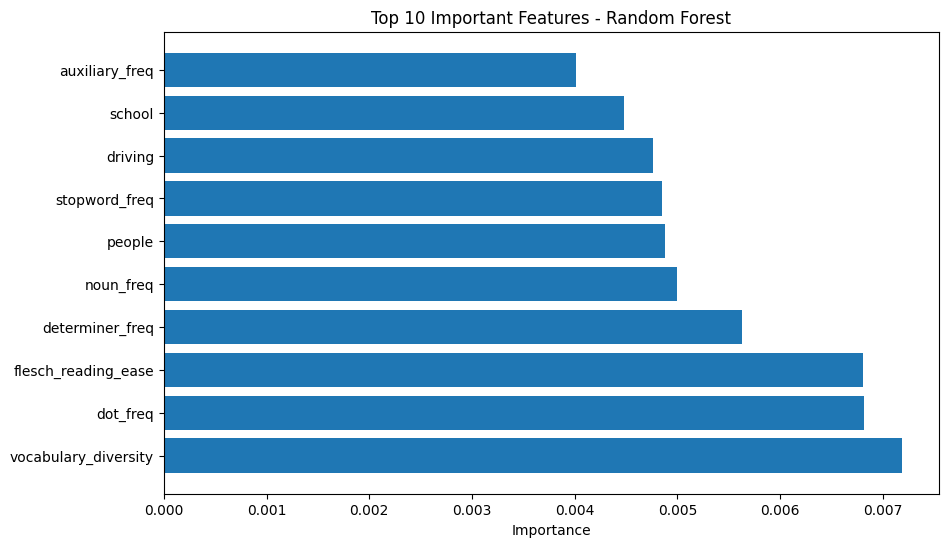

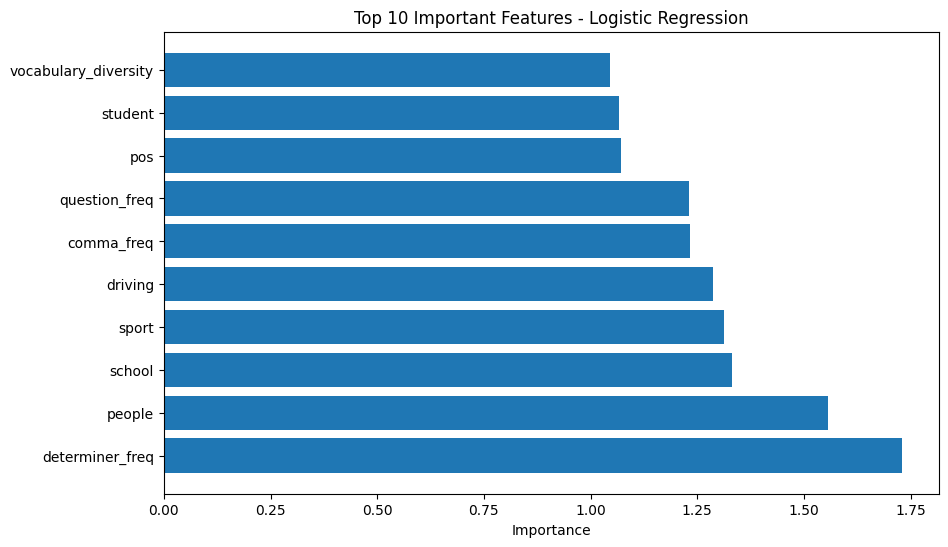

In [129]:
import pandas as pd
from scipy.sparse import load_npz, csr_matrix, hstack
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load datasets
valid_data_x_sparse = load_npz('valid_data_x_sparse.npz')
valid_data_x_dense = pd.read_csv('valid_data_x_dense.csv')
valid_data_y = pd.read_csv('valid_data_y.csv')

# Append names of dense features
feature_names = list(sparse_matrices_feature_names) + list(valid_data_x_dense.columns)  # Explicitly convert to list

# Combine the loaded sparse matrix with the additional features from the dense DataFrame
valid_data_x = hstack([valid_data_x_sparse, csr_matrix(valid_data_x_dense.values)]).toarray()

# Print the shapes of the combined data matrices
print("Features matrix shape:", valid_data_x.shape)
print("Target vector shape:", valid_data_y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    valid_data_x, valid_data_y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train.values.ravel())

# Feature importance from Random Forest
rf_importances = random_forest.feature_importances_
rf_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
print("Top 10 important features in Random Forest:")
print(rf_feature_importance.sort_values(by='Importance', ascending=False).head(10))

# Initialize and train the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression.fit(X_train, y_train.values.ravel())

# Feature importance from Logistic Regression (coefficients)
lr_importances = np.abs(logistic_regression.coef_[0])
lr_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': lr_importances})
print("Top 10 important features in Logistic Regression:")
print(lr_feature_importance.sort_values(by='Importance', ascending=False).head(10))

# Plot feature importance from Random Forest
plt.figure(figsize=(10, 6))
rf_top_features = rf_feature_importance.sort_values(by='Importance', ascending=False).head(10)
plt.barh(rf_top_features['Feature'], rf_top_features['Importance'])
plt.title('Top 10 Important Features - Random Forest')
plt.xlabel('Importance')
plt.show()

# Plot feature importance from Logistic Regression
plt.figure(figsize=(10, 6))
lr_top_features = lr_feature_importance.sort_values(by='Importance', ascending=False).head(10)
plt.barh(lr_top_features['Feature'], lr_top_features['Importance'])
plt.title('Top 10 Important Features - Logistic Regression')
plt.xlabel('Importance')
plt.show()
